In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import pickle
import datetime

import warnings
warnings.filterwarnings('ignore')

In [2]:
MODEL_FOLDER = "./stat_models/"

In [3]:
india_stations_df = pd.read_pickle('../2015-2020-pm25/india_stations.pkl')
india_stations_pm25_list = pd.read_pickle('../2015-2020-pm25/india_stations_pm25.pkl')

In [4]:
import configparser

config = configparser.ConfigParser()
config.read("./config.ini")

city = "Bengaluru"

START = config['period']['start_date']
END   = config['period']['end_date']

In [5]:
city_station_ids = india_stations_df[india_stations_df['City'] == city]['StationId'].values

In [6]:
city_stations_pm25_list = []

for df in india_stations_pm25_list:
    if df['StationId'].values[0] in city_station_ids:
        city_stations_pm25_list.append(df)

In [7]:
india_stations_df

,StationName,StationId,City,Latitude,Longitude
0,"Secretariat, Amaravati - APPCB",AP001,Amaravati,16.504561,80.523517
1,"GVM Corporation, Visakhapatnam - APPCB",AP005,Visakhapatnam,17.748887,83.247789
2,"Railway Colony, Guwahati - APCB",AS001,Guwahati,26.179587,91.784315
3,"DRM Office Danapur, Patna - BSPCB",BR005,Patna,25.585624,85.044299
4,"Govt. High School Shikarpur, Patna - BSPCB",BR006,Patna,25.587980,85.094986
...,...,...,...,...,...
122,"Fort William, Kolkata - WBPCB",WB009,Kolkata,22.554246,88.335874
123,"Jadavpur, Kolkata - WBPCB",WB010,Kolkata,22.495500,88.370900
124,"Rabindra Bharati University, Kolkata - WBPCB",WB011,Kolkata,22.584454,88.359384
125,"Rabindra Sarobar, Kolkata - WBPCB",WB012,Kolkata,22.512145,88.363695


In [8]:
def previous_window_impute(station_df, window_length=14):
    column = "PM2.5"
    try:
        for idx, value in enumerate(station_df[column].values):
            if np.isnan(value):
                station_df[column][idx] = station_df[column][idx - window_length]
    except:
        pass
    return station_df

In [9]:
def series_to_supervised(data, col_name='PM2.5', input_length=7, output_length=1, dropnan=True):
    features = 1 if type(data) is list else data.shape[1]
    df_new = pd.DataFrame(data)
    cols, names = list(), list()
    
    for i in range(input_length, 0, -1):
        cols.append(df_new.shift(i))
        names += [('%s(t-%d)' % (col_name, i)) for j in range(features)]
        
    for i in range(0, output_length):
        cols.append(df_new.shift(-i))
        if i == 0:
            names += [('%s(t)' % (col_name)) for j in range(features)]
        else:
            names += [('%s(t+%d)' % (col_name, i)) for j in range(features)]
    df_final = pd.concat(cols, axis=1)
    df_final.columns = names
    if dropnan:
        df_final.dropna(inplace=True)
    return df_final

In [10]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing


import warnings
warnings.filterwarnings('ignore')

In [11]:
def get_AR_model(training_set, test_set, days):
    
    predictions = np.array([])

    for i in range(0, days):
        model = AutoReg(training_set, lags=5)
        model_fit = model.fit()        
        prediction = model_fit.predict(start=len(training_set), end=len(training_set))
        predictions = np.append(predictions, prediction)
        training_set = np.append(training_set, test_set[i])
        
    score = {
        "r2_score": r2_score(test_set, predictions),
        "mae": mean_absolute_error(test_set, predictions), 
        "rmse": np.sqrt(mean_squared_error(test_set, predictions)),
        "mean": np.mean(test_set)
    }

    return model, score, None, predictions 

def get_ARIMA_model(training_set, test_set, days):
    
    predictions = np.array([])

    for i in range(0, days):
        model = SARIMAX(training_set)
        model_fit = model.fit()        
        prediction = model_fit.predict(start=len(training_set), end=len(training_set))
        predictions = np.append(predictions, prediction)
        training_set = np.append(training_set, test_set[i])
        
    score = {
        "r2_score": r2_score(test_set, predictions),
        "mae": mean_absolute_error(test_set, predictions), 
        "rmse": np.sqrt(mean_squared_error(test_set, predictions)),
        "mean": np.mean(test_set)
    }

    return model, score, None, predictions 

def get_HoltWinters_model(training_set, test_set, days):       
    
    t,d,s,p,b,r = 'add', False, 'mul', 7, False, False
    predictions = np.array([])

    for i in range(0, days):
        model = ExponentialSmoothing(training_set, trend=t, damped=d, seasonal=s, seasonal_periods=p)
        model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)        
        prediction = model_fit.predict(start=len(training_set), end=len(training_set))
        predictions = np.append(predictions, prediction)
        training_set = np.append(training_set, test_set[i])
        
    score = {
        "r2_score": r2_score(test_set, predictions),
        "mae": mean_absolute_error(test_set, predictions), 
        "rmse": np.sqrt(mean_squared_error(test_set, predictions)),
        "mean": np.mean(test_set)
    }

    return model, score, None, predictions

In [12]:
MODEL_LIST = [
    ('AR', get_AR_model),
    ('ARIMA', get_ARIMA_model),
    ('Holt-Winters', get_HoltWinters_model)
]

try:
    import os
    for name, model_fn in MODEL_LIST:
        os.mkdir(MODEL_FOLDER + f"{name}")
except:
    pass

In [13]:
plt.rc('text', usetex=True)  
plt.rc('font', family='sans-serif')

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

def line_format(label):
    if (label.day % 5 == 0):
        return f"{label.day}\n{label.month_name()[:3]}"

def perform_modelling(station_data, training_set, test_set, test_idx_values, days, station_id, show_graph=True):

    best = {}
    best_score = 9e9

    rows = []

    predictions = {}
    predictions['Actual'] = test_set.reshape(-1)

    for name, model_fn in MODEL_LIST:
        details = {}
        regressor, score, scaler, y_pred = model_fn(training_set, test_set, days)
        row = [f"{name}", score['mae'], score['rmse'], score['r2_score'], score['mean']]
        rows.append(row)

        predictions[name + ""] = y_pred.reshape(-1)
        
        details['station_name'] = station_data[0]
        details['station_id'] = station_id
        details['name'] = name + ""
        details['regressor'] = regressor
        details['scaler'] = scaler
        details['score'] = score       
        details['test_set_predictions'] = y_pred
        details['test_set'] = test_set
        
        with open(MODEL_FOLDER + f"{name}/{station_id}_pm25.pkl", "wb") as file:
            pickle.dump(details, file, protocol=4)

        if score['rmse'] < best_score:
            best = details
            best_score = score['rmse']

    model_dfs = pd.DataFrame(rows, columns=["model", "mae", "rmse", "r2_score", "mean"])
    
    test_idx_values += datetime.timedelta(days=1)
    predictions_df = pd.DataFrame(predictions, index=test_idx_values)
    predictions_df.to_pickle(MODEL_FOLDER + f"/{station_id}_predictions.pkl")
    
    if show_graph:
        fig = plt.figure(figsize=(18, 4))
        ax = fig.gca()
        
        predictions_df[['Actual', best['name']]].plot(ax=fig.gca())
        plt.title(f"{station_id} | Test Set", fontsize=14)
        plt.ylabel('PM2.5')
        plt.grid(ls='--')
        
        msg_rmse = f"RMSE: {best['score']['rmse'].round(3)}"
        msg_mae =  f"MAE:  {best['score']['mae'].round(3)}"
        msg_mean = f"MEAN: {best['score']['mean'].round(3)}"
        
        msg = msg_rmse + '\n' + msg_mae + '\n' + msg_mean 
        
        ax.set_xticks(predictions_df.index)
        ax.set_xticklabels(map(line_format, predictions_df.index), rotation=0,  ha="center");
        
        ax.text(0.475, 0.85, msg,
             bbox=dict(facecolor='white', alpha=1),
             horizontalalignment='left',
             verticalalignment='center',
             fontsize=12,
             transform=ax.transAxes)

    return best, model_dfs, predictions_df, ax  

In [14]:
import multiprocessing as mp

manager = mp.Manager()
ax_list = manager.list()

def perform_task(idx):
    
    station_df = city_stations_pm25_list[idx][START:END]

    station_id = station_df['StationId'].values[0]
    
    station_data = india_stations_df[india_stations_df['StationId'] == station_id].values[0]

    station_df['Place'] = station_data[0]
    station_df['City'] = station_data[1]
    station_df['Latitude'] = station_data[3]
    station_df['Longitude'] = station_data[4]
    
    nan_count = station_df[station_df['PM2.5'].isnull()].isna().sum()['PM2.5']
    total = len(station_df['PM2.5'])
    if  (nan_count/total) > float(config['nan']['tolerance']):
        return
        
    station_df = previous_window_impute(station_df)
    station_df = station_df.fillna(station_df.mean())

    station_df.index.freq = 'D'
    station_pm25_df = pd.DataFrame(station_df['PM2.5'])
    
    reframed_df = station_pm25_df
    ratio = 0.3

    length = len(reframed_df)
    limit = (int)(ratio * length)

    training_set, test_set = reframed_df.values[:-limit], reframed_df.values[-limit:]
    test_idx_values = reframed_df.index.to_pydatetime()[-limit:]
    days = len(test_idx_values)

    best, model_dfs, predictions_df, ax = perform_modelling(station_data, training_set, test_set, test_idx_values, days, station_id, show_graph=True)
    
    ax_list.append(ax)

#     with open(MODEL_FOLDER + f"{station_id}_pm25.pkl", "wb") as file:
#         pickle.dump(best, file, protocol=4)

In [15]:
pool = mp.Pool(mp.cpu_count())

pool.map(perform_task, [idx for idx in range(len(city_stations_pm25_list))])
pool.close()

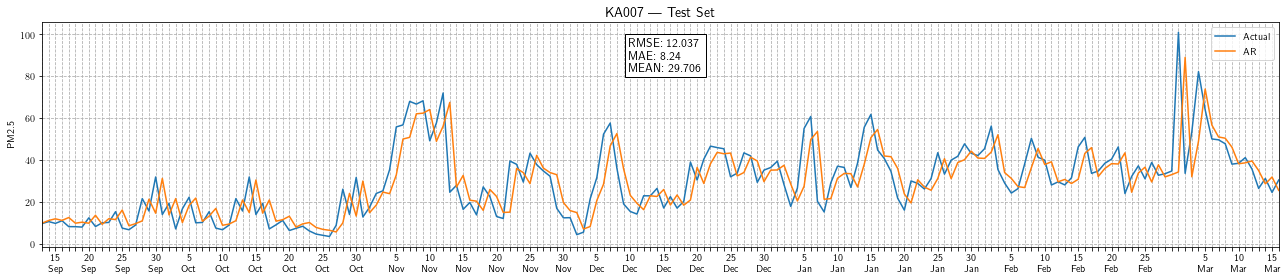

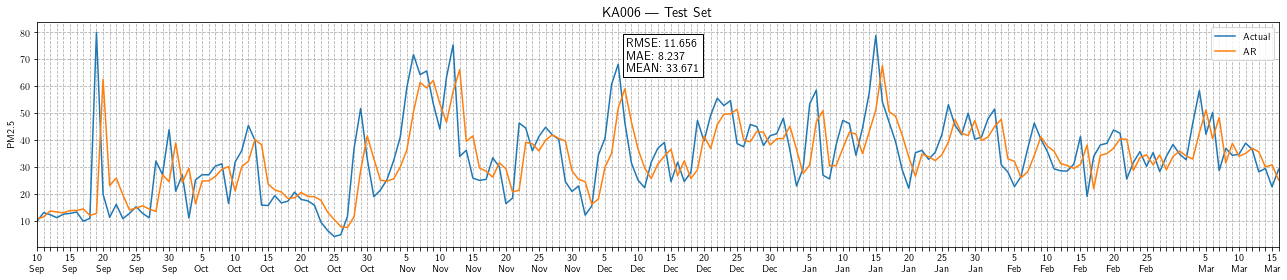

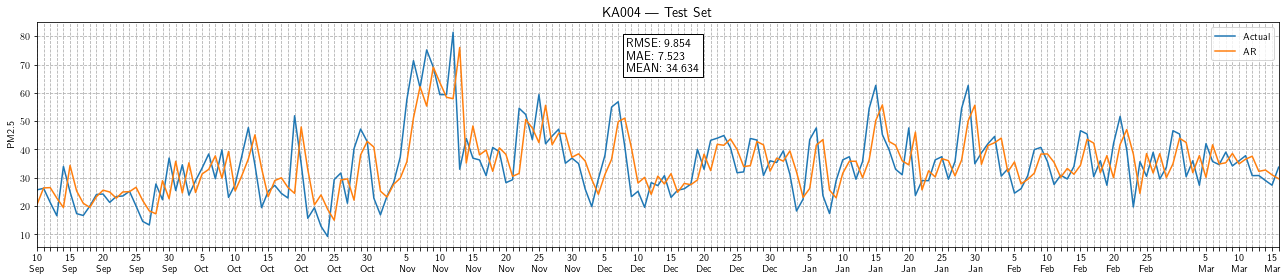

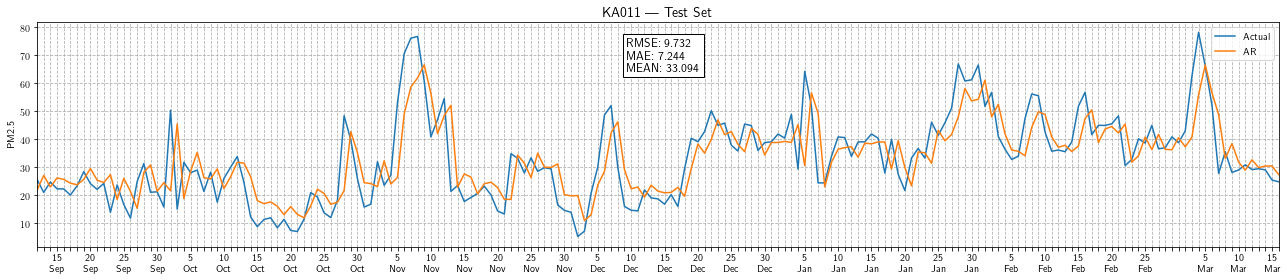

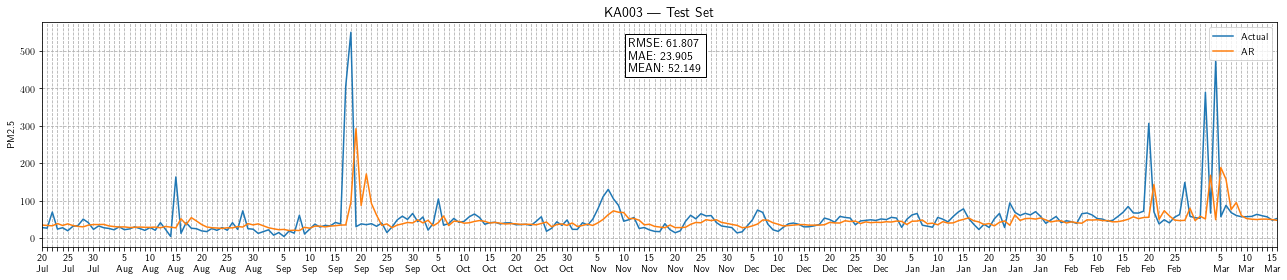

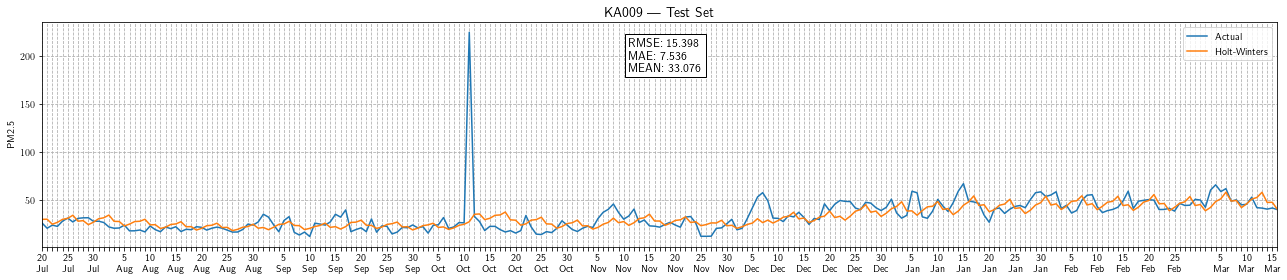

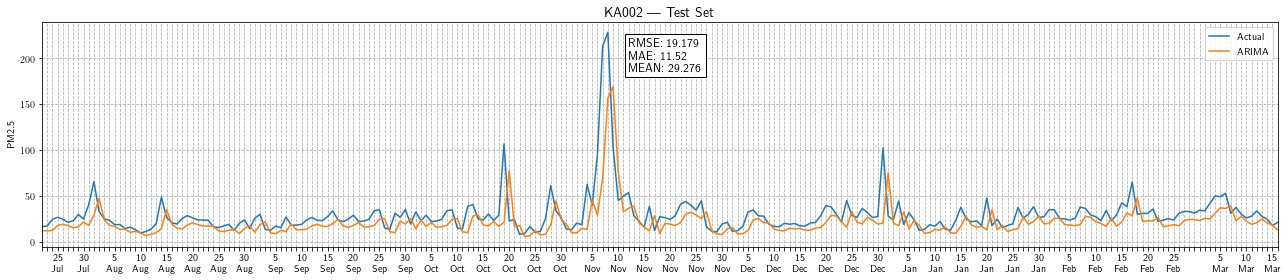

In [16]:
for ax in ax_list:
    plt.show()